In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import jax
jax.config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import numpy.random as npr
from networks.dense import DenseNet
from networks.encoders import SigmaEncoder
from networks.decoders import SigmaDecoder
from models.SVAE_GMM import SVAE_GMM
from functools import partial
import flax.linen as nn
from networks.layers import LayerNorm
from tensorflow_probability.substrates.jax import distributions as tfd
import optax 
from train_utils import load_state, save_state, train_step, eval_step, create_dual_train_state, create_train_state

Let's start by generating a toy data set, as seen in [the original SVAE paper](https://proceedings.neurips.cc/paper/2016/file/7d6044e95a16761171b130dcb476a43e-Paper.pdf). The data-generating code is taken from [their repository](https://github.com/mattjj/svae).

In [2]:
def make_dynamic_pinwheel_data(radial_std, tangential_std, rate, num_classes=5, num_per_phase=50):
    num_phases = num_classes * 2 - 1
    N = num_per_phase * num_phases

    rads = np.linspace(0, 2*np.pi, num_classes, endpoint=False)

    features = npr.randn(N, 2) \
        * np.array([radial_std, tangential_std])
    features[:,0] += 1.
    features = features[np.argsort(features[:, 0])]
    features = features.reshape((num_per_phase,num_phases,2)).swapaxes(0,1)
    for i in range(1,num_phases,2):
        features[i] = np.flip(features[i],0)
    features = features.reshape((-1,features.shape[-1]))

    labels = np.zeros((num_phases,num_per_phase)).view(int)
    j = num_classes - 1
    n_rotations = int(num_per_phase/num_classes) + 1
    for i in range(num_phases):
        labels[2*i] = np.repeat(j-i,num_per_phase)
        if i ==j:
            break
        labels[2*i+1] = np.tile(np.arange(num_classes),n_rotations)[j-i:-(i+1)]

    labels = labels.flatten()

    angles = rads[labels] + rate * np.exp(features[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))
    return 10 * np.einsum('ti,tij->tj', features, rotations)

np.random.seed(47)
data = jnp.asarray(make_dynamic_pinwheel_data(0.3, 0.05, 0.25))


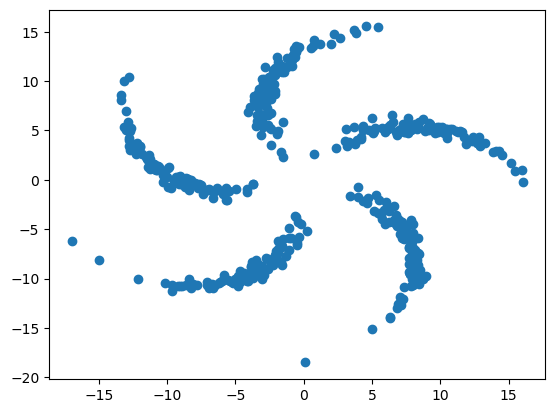

In [3]:
import matplotlib.pyplot as plt
plt.scatter(data[:,0], data[:,1])

We'll start by specifying the model architecture

In [4]:
cfg = lambda:0

# network hyperparameters
cfg.latent_D = 4
cfg.K = 10
cfg.encoder_stage_sizes = [1, 1, 1]
cfg.encoder_hidden_sizes = [256, 256, 256]
cfg.decoder_stage_sizes = [1, 1, 1]
cfg.decoder_hidden_sizes = [256, 256, 256]

# Define networks
encoder_network = partial(DenseNet, resnet=False, 
                          stage_sizes=cfg.encoder_stage_sizes, 
                          hidden_sizes=cfg.encoder_hidden_sizes,
                          activation=nn.gelu,
                          norm_cls=LayerNorm)

decoder_network = partial(DenseNet, resnet=False, 
                          stage_sizes=cfg.decoder_stage_sizes, 
                          hidden_sizes=cfg.decoder_hidden_sizes,
                          activation=nn.gelu,
                          norm_cls=LayerNorm)
                          
encoder = partial(SigmaEncoder, network_cls=encoder_network)
decoder = partial(SigmaDecoder, network_cls=decoder_network, likelihood=tfd.Normal)

# Creat model
model_builder = partial(SVAE_GMM, latent_D= cfg.latent_D, K = cfg.K, 
                        input_D = data.shape[-1], encoder_cls=encoder, decoder_cls=decoder)

# Set optimization hyperparameters
cfg.lr_net = 1e-4
cfg.lr_pgm = 1e-4
cfg.lr_decay_steps = 250000
cfg.lr_final_mult = 0.01
cfg.learning_alg_pgm = 'sgd'
cfg.learning_alg_net = 'adam'
cfg.init_rng = jax.random.PRNGKey(47)
cfg.epochs = 1000

net_schedule = optax.cosine_decay_schedule(cfg.lr_net, cfg.lr_decay_steps, cfg.lr_final_mult)
pgm_schedule = optax.cosine_decay_schedule(cfg.lr_pgm, cfg.lr_decay_steps, cfg.lr_final_mult)
model, state = create_dual_train_state(cfg.init_rng, net_schedule, pgm_schedule, model_builder, data.shape, learning_alg_net=cfg.learning_alg_net, learning_alg_pgm=cfg.learning_alg_pgm)

... and the warmup model's architecture. Just as in the SLDS, we will pre-train with a VAE to get latent codes which contain *some* semantic information about the data before we start clustering. Training the SVAE-GMM from scratch has a much higher chance of collapsing to a small number of states.

In [5]:
from models.VAE import VAE
from train_utils import create_train_state 

warmup_model_builder = partial(VAE, latent_D=cfg.latent_D, input_D=data.shape[-1],
                               encoder_cls=encoder, decoder_cls=decoder)
warmup_model, warmup_state = create_train_state(cfg.init_rng, cfg.lr_net, warmup_model_builder, data.shape)


In [6]:
import tqdm
cfg.num_steps = 20000
running_loss = 0.0

pbar = tqdm.trange(cfg.num_steps)
for epoch in pbar:
    warmup_state, metrics = train_step(warmup_state, data, N_data=4500)

    running_loss = metrics['loss'].item() if running_loss == 0.0 else (running_loss * 0.9 + metrics['loss'].item() * 0.1)
    
    pbar.set_description("Loss: %.3f" % running_loss)

    if np.isnan(metrics['loss'].item()):
        break

Loss: 3157.444: 100%|██████████| 20000/20000 [00:30<00:00, 657.84it/s]


As with the SLDS, we do not pre-train until convergence; doing so might make the clusters highly non-Gaussian in the latent space, and that local optimum for the encoder/decoder is difficult to escape from.

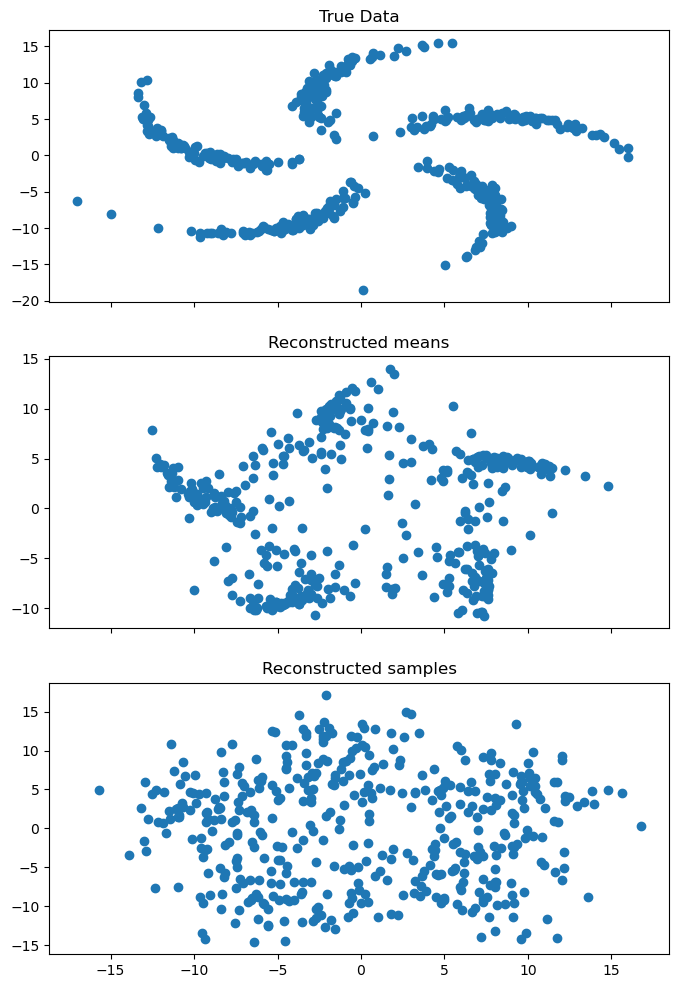

In [7]:
f, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

ax[0].scatter(data[:,0], data[:,1])
ax[0].set_title('True Data')

_, _, likelihood, aux = eval_step(warmup_state, data, N_data=450)
recon = likelihood.mean()
ax[1].scatter(recon[:,0], recon[:,1])
ax[1].set_title('Reconstructed means')

recon = likelihood.sample(seed=jax.random.PRNGKey(47))
ax[2].scatter(recon[:,0], recon[:,1])
ax[2].set_title('Reconstructed samples')

plt.show()

We update the SVAE-GMM with the encoder and decoder from the warmup model... (see notebook `04` for a note about initializing the cluster means. For real data, we initialize using `bnpy`, which this simple data can be initialized with cluster means drawn from standard normal distributions. Expecting some of these states to collapse due to unlucky initializations, we use $10 > 5$ clusters

In [8]:
new_params = state.params.copy({'encoder': warmup_state.params['encoder'], 
                                'decoder': warmup_state.params['decoder']})
state = state.replace(params = new_params)

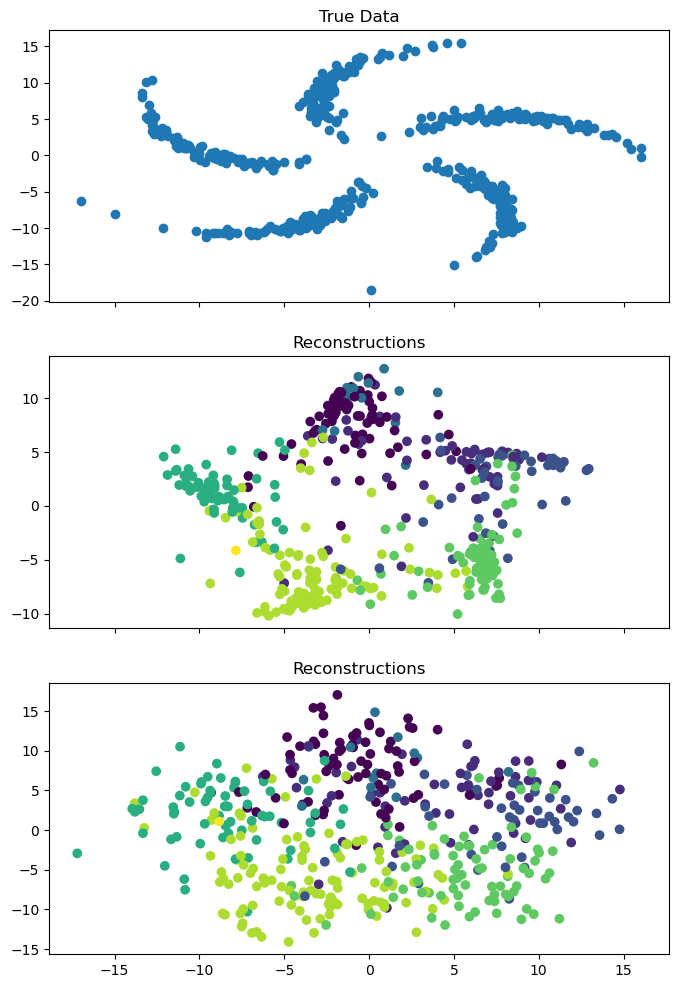

In [9]:
f, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

ax[0].scatter(data[:,0], data[:,1])
ax[0].set_title('True Data')

_, _, likelihood, aux = eval_step(state, data, N_data=450)
recon = likelihood.mean()
color = jnp.argmax(aux['aux'][1],1)
ax[1].scatter(recon[:,0], recon[:,1], c=color)
ax[1].set_title('Reconstructions')


recon = likelihood.sample(seed=jax.random.PRNGKey(47))
ax[2].scatter(recon[:,0], recon[:,1], c=color)
ax[2].set_title('Reconstructions')

plt.show()

... and train!

In [10]:
import tqdm

cfg.num_steps = 20000
running_loss = 0.0

pbar = tqdm.trange(cfg.num_steps)
for epoch in pbar:
    state, metrics = train_step(state, data, N_data=4500)

    running_loss = metrics['loss'].item() if running_loss == 0.0 else (running_loss * 0.9 + metrics['loss'].item() * 0.1)
    states_in_use = jnp.sum(metrics['aux'].mean(0) > 0.05)
    
    pbar.set_description("Loss: %.3f, States in use: %d" % (running_loss, states_in_use))

    if np.isnan(metrics['loss'].item()):
        break

Loss: 2966.566, States in use: 5: 100%|██████████| 20000/20000 [02:00<00:00, 166.20it/s]


The GMM prior in the latent space prunes away unused clusters and learns an interpretable clustering of the data!

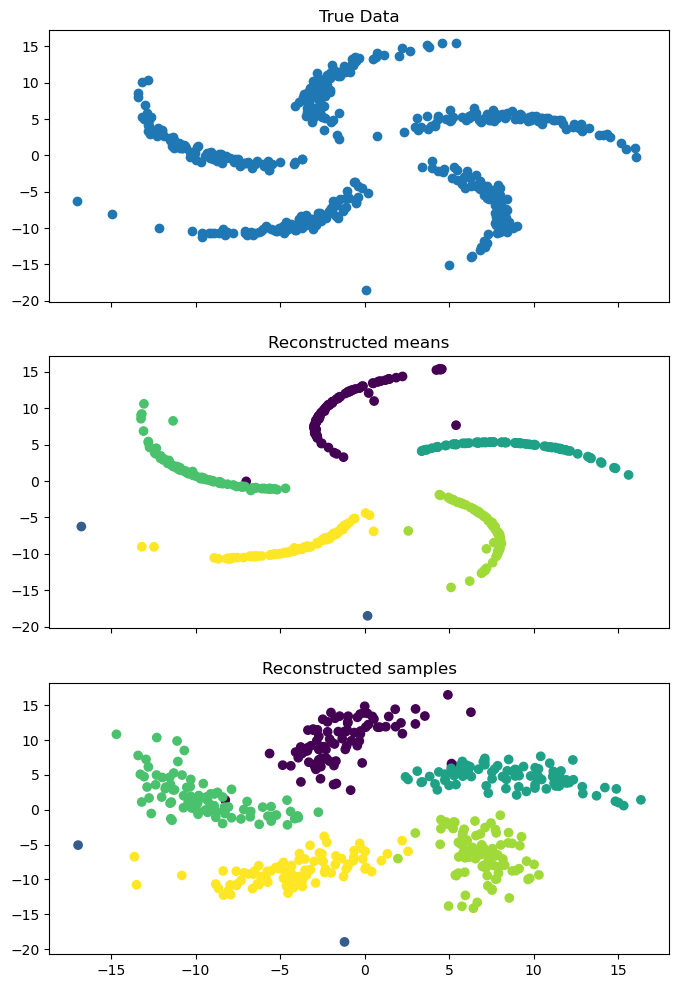

In [11]:
f, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

ax[0].scatter(data[:,0], data[:,1])
ax[0].set_title('True Data')

_, _, likelihood, aux = eval_step(state, data, N_data=450)
recon = likelihood.mean()
color = jnp.argmax(aux['aux'][1],1)
ax[1].scatter(recon[:,0], recon[:,1], c=color)
ax[1].set_title('Reconstructed means')


recon = likelihood.sample(seed=jax.random.PRNGKey(47))
ax[2].scatter(recon[:,0], recon[:,1], c=color)
ax[2].set_title('Reconstructed samples')

plt.show()